<a href="https://colab.research.google.com/github/oscarserc/TESIS_Transformers/blob/main/Practica_b__Transformer_Decoder_Pytorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# INSTALAMOS PyTorch_lightning
# ============================

!pip install PyTorch_lightning

     |████████████████████████████████| 919 kB 5.3 MB/s 
     |████████████████████████████████| 119 kB 44.0 MB/s 
     |████████████████████████████████| 282 kB 43.4 MB/s 
     |████████████████████████████████| 829 kB 37.4 MB/s 
     |████████████████████████████████| 636 kB 47.3 MB/s 
     |████████████████████████████████| 1.3 MB 38.0 MB/s 
     |████████████████████████████████| 142 kB 32.9 MB/s 
     |████████████████████████████████| 294 kB 68.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9d3eb4b4b4f4b33a98dc4867b46e151eefb08a36382c499e68ec28de04a6ee01
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [ ]:
# CARGAMOS LAS LIBRERÍAS
# ======================

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [ ]:
# PREPARAMOS LA CARGA DE DATOS
# ============================

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, max_len=8):
    self.X = X
    self.y = y
    self.max_len = max_len

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = torch.tensor(self.X[ix]).float().view(1, 28, 28)
    # Añadimos códigos: 2(end of sentence) 1(start of sentence)
    caption = torch.tensor([1] + self.y[ix] + [2]).long()
    # 0 (para padding)
    caption = F.pad(caption, (0, self.max_len - len(caption)), 'constant', 0)
    return img, caption

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int = 1024):
    super().__init__()
    self.batch_size = batch_size
    self.vocab = 'abcdefghijklmnopqrstuvwxyz'
    self.len_vocab = len(self.vocab) + 3 

  def number2caption(self, ix):
    if ix == 0: return 'cero' 
    if ix == 1: return 'uno' 
    if ix == 2: return 'dos' 
    if ix == 3: return 'tres' 
    if ix == 4: return 'cuatro' 
    if ix == 5: return 'cinco' 
    if ix == 6: return 'seis' 
    if ix == 7: return 'siete' 
    if ix == 8: return 'ocho'
    if ix == 9: return 'nueve'

  def caption2ixs(self, caption):
    return [self.vocab.index(c) + 3 for c in caption]

  def ixs2caption(self, ixs):
    return ('').join([self.vocab[ix - 3] for ix in ixs if ix not in [0, 1, 2]])

  def setup(self, stage = None):
    mnist = fetch_openml('mnist_784', version=1)
    X, y  = mnist['data'], mnist['target'].astype(np.int)
    # convertir etiquetas en palabras
    captions = [self.number2caption(ix) for ix in y]
    # cada letra tiene asociado un número
    encoded  = [self.caption2ixs(caption) for caption in captions]
    X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., encoded[:60000], encoded[60000:]
    self.train_ds = Dataset(X_train, y_train)
    self.val_ds   = Dataset(X_test,  y_test)

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, pin_memory=True)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size, pin_memory=True)



In [ ]:
# INSTANCIAMOS Y PROBAMOS EN TIPO DE SALIDA QUE GENERA
# ====================================================

dm = MNISTDataModule(batch_size=64)
dm.setup()
imgs, captions = next(iter(dm.train_dataloader()))
imgs.shape, captions.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 8]))

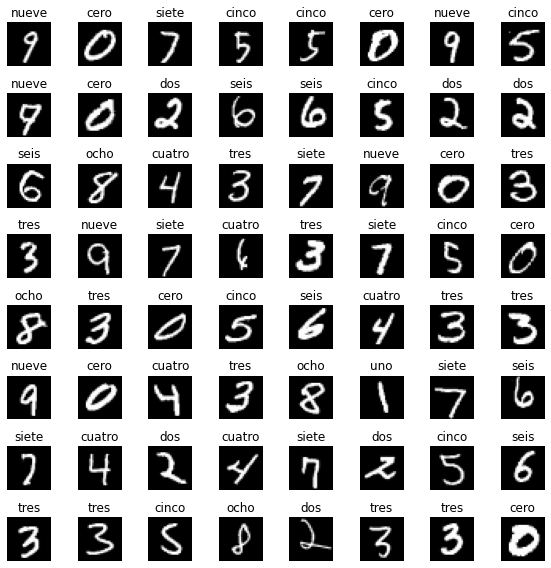

In [ ]:
# DIBUJAMOS ALGUNOS DE LOS DÍGITOS
# ================================

r, c = 8, 8
fig = plt.figure(figsize=(r,c))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, caption = imgs[ix], captions[ix]
    ax.axis('off')
    ax.imshow(img.squeeze(0), cmap='gray')
    label = dm.ixs2caption(caption)
    ax.set_title(label)
plt.tight_layout()
plt.show()    

In [ ]:
# MODELO
# ======
#
# Emplearemos la implementación de Transformer que ofrece PyTorch
# ---------------------------------------------------------------

import torch.nn as nn

class PatchEmbedding(nn.Module):
  def __init__(self, img_size, patch_size, in_chans, embed_dim):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = ( img_size // patch_size ) ** 2
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.proj(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x


In [ ]:
# INSTANCIAMOS
# ============

pe = PatchEmbedding(28, 7, 1, 100)
out = pe(imgs)
out.shape


torch.Size([64, 16, 100])